In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter

import pandas as pd
import numpy as np

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


%load_ext memory_profiler

print(tf.__version__)

2.6.0


In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
df = pd.read_csv(r"C:\Users\stezo\Desktop\Text_classification\Software.csv",encoding='latin-1')
df.head(3)

,Unnamed: 0,rating,verified,reviewTime,reviewerID,productID,reviewText,summary,unixReviewTime
0,0,4,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,The materials arrived early and were in excell...,Material Great,1394496000
1,1,4,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,I am really enjoying this book with the worksh...,Health,1393113600
2,2,1,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200


In [4]:
df['label'] = df['rating'].apply(lambda x: 1 if x > 3 else 0 )
amazon_data = df.loc[:,('reviewText','label')]
amazon_data.columns = ['text', 'label']

amazon_data

,text,label
0,The materials arrived early and were in excell...,1
1,I am really enjoying this book with the worksh...,1
2,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",0
3,This book was missing pages!!! Important pages...,0
4,I have used LearnSmart and can officially say ...,1
...,...,...
423348,I love it .,1
423349,No instructions.....No Help unless you want to...,0
423350,it's a joke,0
423351,I have multiple licenses of the Antivirus. I h...,1


In [5]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = str(text).translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [11]:
%time amazon_data['text'].dropna(axis = 0, how ='any',inplace=True)

%time amazon_data['text'] = amazon_data['text'].apply(clean_text)
amazon_data['label'].value_counts()

Wall time: 37.2 ms
Wall time: 7.6 s


1    256672
0    166681
Name: label, dtype: int64

In [12]:
amazon_data[amazon_data['label']==0]

,text,label
2,you are taking this class dont waste your mone...,0
3,this book was missing pages important pages co...,0
6,you live mars and never heard the internet thi...,0
10,maybe its just have marketing background but d...,0
12,not worth the price most the concepts are pret...,0
...,...,...
423345,the images are deceptive the pendant small you...,0
423346,small its hard make out what when you wear,0
423347,fault shorter than expected,0
423349,instructionsno help unless you want pay for help,0


In [238]:
# Podział na zbiór trenningowy oraz testowy.
X_train, X_valid, y_train, y_valid = train_test_split(amazon_data['text'].tolist(),
                                                      amazon_data['label'].tolist(),
                                                      train_size=0.7,
                                                      test_size=0.3,
                                                      stratify = amazon_data['label'].tolist(),\
                                                      random_state=0)

In [239]:
num_words = 5000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 79, 14, 6]]


In [240]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )

sequence_length = 200
x_train = pad_sequences(x_train, padding='post', maxlen=sequence_length)
x_valid = pad_sequences(x_valid, padding='post', maxlen=sequence_length)

train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))

sequence_length_cnn = 200
x_train_cnn = pad_sequences(x_train, padding='post', maxlen=sequence_length_cnn)
x_valid_cnn = pad_sequences(x_valid, padding='post', maxlen=sequence_length_cnn)


train_ds_cnn = tf.data.Dataset.from_tensor_slices((x_train_cnn,train_labels))
valid_ds_cnn = tf.data.Dataset.from_tensor_slices((x_valid_cnn,valid_labels))

C:\Users\stezo\AppData\Local\Temp/ipykernel_23572/138712046.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
C:\Users\stezo\AppData\Local\Temp/ipykernel_23572/138712046.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )


In [242]:
max_features =5000
embedding_dim =16


RNN = tf.keras.Sequential()
RNN.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
RNN.add(tf.keras.layers.Dropout(0.2))
RNN.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0,return_sequences=True,
                                                             kernel_regularizer=regularizers.l2(0.005),
                                                             bias_regularizer=regularizers.l2(0.005)))
RNN.add(tf.keras.layers.Flatten())
RNN.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001), input_shape=(160,10)))
RNN.add(tf.keras.layers.Dropout(0.2))

RNN.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
RNN.add(tf.keras.layers.Dropout(0.2))
RNN.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#RNN.summary()
RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
            optimizer=tf.keras.optimizers.Adam(1e-3),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [243]:
%%time
epochs = 50
historyRNN = RNN.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=0)

print(f"RNN accuracy ->: {round(historyRNN.history['binary_accuracy'][-1], 5)}")
print(f"RNN val accuracy ->: {round(historyRNN.history['val_binary_accuracy'][-1], 5)}")

RNN accuracy ->: 0.85628
RNN val accuracy ->: 0.86746
Wall time: 5min 57s


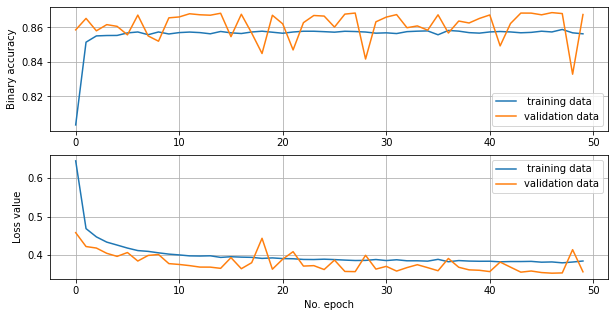

In [244]:
# plot 
plt.rcParams['figure.figsize'] = [10, 5]

f, axs = plt.subplots(2, 1)
#axs[0].subplot(211)
axs[0].plot(historyRNN.history['binary_accuracy'], label=' training data')
axs[0].plot(historyRNN.history['val_binary_accuracy'], label='validation data')
#axs[0].set_title('Binary accuracy for Text Classification')
axs[0].set_ylabel('Binary accuracy')
#axs[0].set_xlabel('No. epoch')
axs[0].legend(loc="lower right")
axs[0].grid(True)

axs[1].plot(historyRNN.history['loss'], label=' training data')
axs[1].plot(historyRNN.history['val_loss'], label='validation data')
#axs[1]title('Loss for Text Classification')
axs[1].set_ylabel('Loss value')
axs[1].set_xlabel('No. epoch')
axs[1].legend(loc="upper right")
axs[1].grid(True)

In [245]:
embedding_dim = 16

modelCNN = tf.keras.Sequential()
modelCNN.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, 
                                       input_length=sequence_length_cnn,
                                       embeddings_regularizer = regularizers.l2(0.005))) 
modelCNN.add(tf.keras.layers.Conv1D(filters=32, kernel_size=16, activation='relu'))
modelCNN.add(tf.keras.layers.MaxPooling1D(pool_size=1))
modelCNN.add(tf.keras.layers.Flatten())
modelCNN.add(tf.keras.layers.Dense(20, activation='relu'))
modelCNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

modelCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=tf.keras.metrics.BinaryAccuracy())
#modelCNN.summary()

In [246]:
%%time
epochs = 20
historyCNN = modelCNN.fit(train_ds_cnn.shuffle(5000).batch(1024),
                       epochs= epochs, 
                       validation_data=valid_ds_cnn.batch(1024), 
                       verbose=0)

print(f"CNN accuracy ->: {round(historyCNN.history['binary_accuracy'][-1], 5)}")
print(f"CNN val accuracy ->: {round(historyCNN.history['val_binary_accuracy'][-1], 5)}")

CNN accuracy ->: 0.90334
CNN val accuracy ->: 0.89318
Wall time: 1min 10s


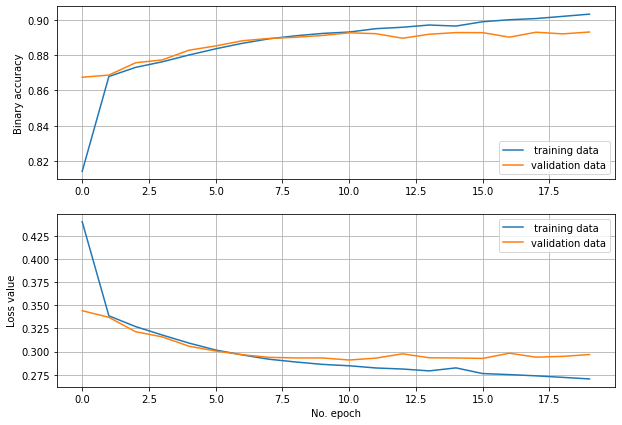

In [247]:
# plot 
plt.rcParams['figure.figsize'] = [10, 7]

f, axs = plt.subplots(2, 1)
#axs[0].subplot(211)
axs[0].plot(historyCNN.history['binary_accuracy'], label=' training data')
axs[0].plot(historyCNN.history['val_binary_accuracy'], label='validation data')
#axs[0].set_title('Binary accuracy for Text Classification')
axs[0].set_ylabel('Binary accuracy')
#axs[0].set_xlabel('No. epoch')
axs[0].legend(loc="lower right")
axs[0].grid(True)

axs[1].plot(historyCNN.history['loss'], label=' training data')
axs[1].plot(historyCNN.history['val_loss'], label='validation data')
#axs[1]title('Loss for Text Classification')
axs[1].set_ylabel('Loss value')
axs[1].set_xlabel('No. epoch')
axs[1].legend(loc="upper right")
axs[1].grid(True)